In [108]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.neural_network import MLPClassifier
import statsmodels.graphics.tsaplots as tsplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa import stattools as stt
from statsmodels import tsa
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import warnings

warnings.filterwarnings("ignore")

def is_stationary(df, maxlag=52, autolag=None, regression='c'):
    adf_test = stt.adfuller(df.values,maxlag=maxlag, autolag=autolag, regression=regression)
#     print(adf_test)
    adf = adf_test[0]
    cv_5 = adf_test[4]["5%"]
    result = adf < cv_5
#     print(adf, '--', cv_5, result)
    return result


def d_param(df, max_lag=52):
    d = 0
    if ~is_stationary(df):
        for i in range(1, max_lag):
            if is_stationary(df.diff(i).dropna()):
                d = i
                break;
    return d

def ARMA_params(df):
    p, q = tsa.stattools.arma_order_select_ic(np.asarray(df.dropna()),ic='aic').aic_min_order
    return p, q


filePath = "Datasets/daily-min-temperatures.csv"
# filePath = "Datasets/daily-total-female-births.csv"
# filePath = "Datasets/monthly-sunspots.csv"
# filePath = "Datasets/shampoo.csv"


csvFile = pd.read_csv(filePath)
print(csvFile)

            Date  Temp
0     1981-01-01  20.7
1     1981-01-02  17.9
2     1981-01-03  18.8
3     1981-01-04  14.6
4     1981-01-05  15.8
...          ...   ...
3645  1990-12-27  14.0
3646  1990-12-28  13.6
3647  1990-12-29  13.5
3648  1990-12-30  15.7
3649  1990-12-31  13.0

[3650 rows x 2 columns]


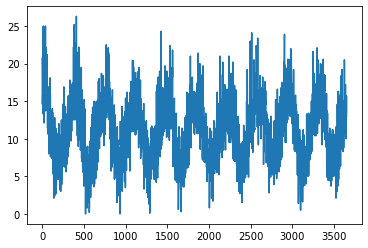

In [109]:
df1 = csvFile['Temp']
# df1 = csvFile['Value']
X = df1.values
plt.plot(X)

ADF Statistic: -4.913036
p-value: 0.000033
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
True


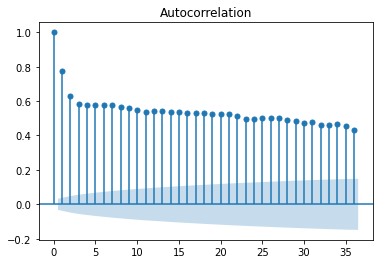

<Figure size 432x288 with 0 Axes>

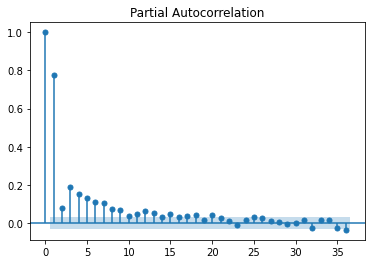

In [110]:
# result = adfuller(X, autolag='aic')
result = adfuller(df1, maxlag=52, autolag=None, regression='c')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

print(is_stationary(df1))
tsplot.plot_acf(X)
plt.figure()
tsplot.plot_pacf(X)    
plt.show()

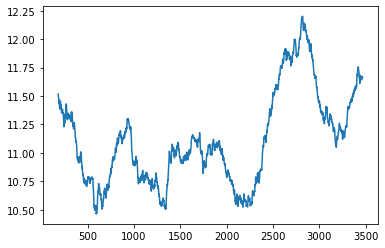

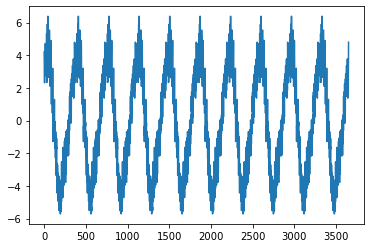

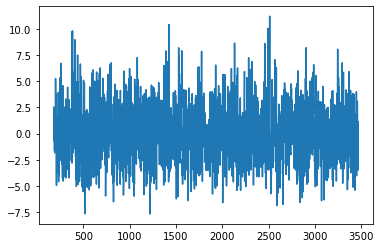

In [111]:
decomp = sm.tsa.seasonal_decompose(X, model='additive', period=365)
trend = decomp.trend
seas = decomp.seasonal
resid = decomp.resid
plt.plot(trend)
plt.figure()
plt.plot(seas)
plt.figure()
plt.plot(resid)
plt.show()
# trend = trend[~np.isnan(trend)]




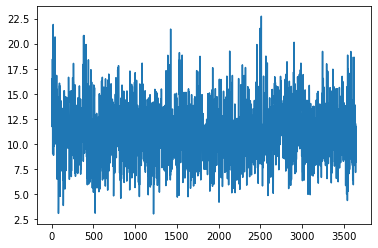

In [112]:
deseasonalized_series = X - seas
deseasonalized_series = deseasonalized_series[~np.isnan(deseasonalized_series)]
Y_deSd = pd.DataFrame(deseasonalized_series)
Y_deSd.dropna(inplace=True)
plt.plot(Y_deSd)

In [116]:
trainRatio = .99
thresh = int(Y_deSd.size*trainRatio)
print(thresh)
Y_deSd1 = Y_deSd[:thresh]
d = d_param(Y_deSd1)

res = sm.tsa.arma_order_select_ic(Y_deSd1, ic=["aic", "bic"], trend="c")
print(res.aic_min_order)
print(res.bic_min_order)
print(d)

3577
(2, 2)
(2, 2)
0


In [119]:

def evaluate_arima_model(X, arima_order, trainRatio):
    # prepare training dataset
    train_size = int(len(X)*trainRatio)
    train, test = X[:train_size], X[train_size:]

    history = [x for x in train]
    

    # make predictions
    predictions = []
    for i in range(0,len(test)):
        history1 = pd.DataFrame(np.asarray(history))

        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast(steps=1)[0]

        predictions.append(yhat)
        history.append(test[i])
        print(i,'/',len(test))
        
    mse_error = mean_squared_error(test, predictions)
    mape_error = mean_absolute_percentage_error(test, predictions)

    return mse_error, mape_error
print(d)
p = 2
d = 1
q = 2

arima_order = (p,d,q)
print(arima_order)
err = evaluate_arima_model(Y_deSd1.values, arima_order, trainRatio)
print(err)


0
(2, 1, 2)
0 / 72
1 / 72
2 / 72
3 / 72
4 / 72


KeyboardInterrupt: 

In [94]:
arima_order = (p,d,q)
print(Y_deSd.values)
xxx = np.squeeze(Y_deSd.values)
print(xxx)
# err = evaluate_arima_model(xxx, arima_order, trainRatio)

XXX = xxx
train_size = int(len(XXX)*trainRatio)
train, test = XXX[:train_size], XXX[train_size:]

history = [x for x in train]

history1 = pd.DataFrame(np.asarray(history))
# make predictions
predictions = []
model1       = ARIMA(history1, order=(p,d,q))
model_fit1   = model1.fit(disp=0)
# forecastedS1 = model_fit1.forecast(steps=1)[0]


# predictions.append(yhat)
# history.append(test[i])

[[16.49738757]
 [14.01997509]
 [15.67574373]
 ...
 [10.95480005]
 [11.27699183]
 [ 8.19820949]]
[16.49738757 14.01997509 15.67574373 ... 10.95480005 11.27699183
  8.19820949]


ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [86]:

# def evaluate_arima_model(X, arima_order, trainRatio):
#     # prepare training dataset
#     train_size = int(len(X)*trainRatio)
#     train, test = X[:train_size], X[train_size:]

#     history = [x for x in train]
    

#     # make predictions
#     predictions = []
#     for i in range(0,len(test)):
#         history1 = pd.DataFrame(np.asarray(history))

# #         model = ARIMA(history1, order=arima_order)
# #         model_fit = model.fit(disp=0)
# #         yhat = model_fit.forecast(steps=1)[0]
        
#         model1       = ARIMA(history1, order=(p,d,q))
#         model_fit1   = model1.fit(disp=0)
#         forecastedS1 = model_fit1.forecast(steps=1)[0]

    
#         predictions.append(yhat)
#         history.append(test[i])
#     # calculate out of sample error
#     error = mean_squared_error(test, predictions)
# #     error = 10
#     return error

# arima_order = (p,d,q)
# print(Y_deSd.values)
# xxx = np.squeeze(Y_deSd.values)
# print(xxx)
# err = evaluate_arima_model(xxx, arima_order, trainRatio)
# print(err)


[[16.49738757]
 [14.01997509]
 [15.67574373]
 ...
 [10.95480005]
 [11.27699183]
 [ 8.19820949]]
[16.49738757 14.01997509 15.67574373 ... 10.95480005 11.27699183
  8.19820949]


ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [91]:
model1       = ARIMA(Y_deSd, order=(p,d,q))
model_fit1   = model1.fit(disp=1)
forecastedS1 = model_fit1.forecast(steps=5)[0]
print(forecastedS1)

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.